<a href="https://colab.research.google.com/github/mhugman/MLChallenge/blob/master/Senseye_Challenge_Hugman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os
from google.colab import files
from google.colab import drive

In [4]:
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir("drive/My Drive/Colab Notebooks")

In [0]:
path_lbl = "masks_small"
path_img = "imgs_small"

In [10]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('imgs_small/set_31_frame_123.jpg'),
 PosixPath('imgs_small/set_31_frame_182.jpg'),
 PosixPath('imgs_small/set_31_frame_154.jpg')]

In [11]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('masks_small/set_64_frame_185.png'),
 PosixPath('masks_small/set_65_frame_51.png'),
 PosixPath('masks_small/set_65_frame_1.png')]

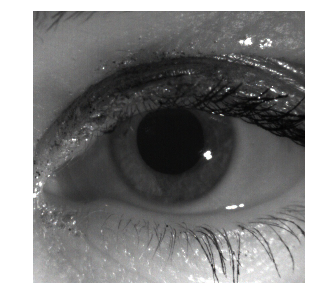

In [12]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl + "/" + f'{x.stem}.png'

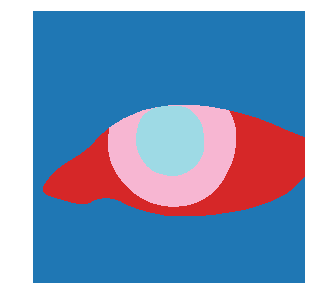

In [14]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [15]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([816, 816]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [0]:
codes = [ "background", "sclera", "iris", "pupil"]

In [17]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [18]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.2)
       .label_from_func(get_y_fn, classes=codes))
src



LabelLists;

Train: LabelList (400 items)
x: SegmentationItemList
Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816)
y: SegmentationLabelList
ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816)
Path: imgs_small;

Valid: LabelList (100 items)
x: SegmentationItemList
Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816)
y: SegmentationLabelList
ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816)
Path: imgs_small;

Test: None

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [20]:
data

ImageDataBunch;

Train: LabelList (400 items)
x: SegmentationItemList
Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408)
y: SegmentationLabelList
ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408)
Path: imgs_small;

Valid: LabelList (100 items)
x: SegmentationItemList
Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408)
y: SegmentationLabelList
ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408)
Path: imgs_small;

Test: None

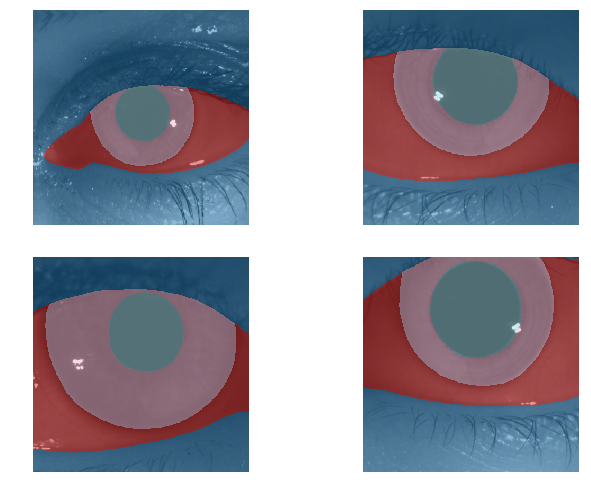

In [21]:
data.show_batch(2, figsize=(10,7))

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [24]:
metrics

<function __main__.acc_camvid>

In [0]:
wd=1e-2

In [26]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 17.1MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


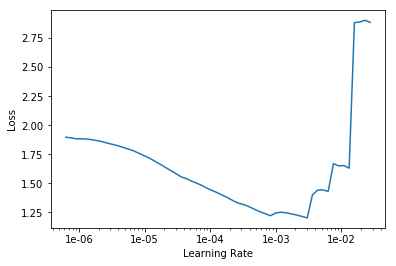

In [27]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=5e-2

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)


epoch,train_loss,valid_loss,acc_camvid,time
0,530.856201,0.539394,0.365704,02:34
1,142.120926,0.324750,0.675855,02:14
2,47.445297,0.264499,0.730193,02:14
3,17.024128,0.261342,0.711425,02:12
4,9.499408,1.146896,0.428962,02:11


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.show_results(rows=10, figsize=(8,9))

In [0]:
learn.unfreeze()


In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
lrs

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [0]:
learn.save('stage-2');


In [0]:
learn.show_results(rows=5, figsize=(8,9))

In [0]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
data

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)


In [0]:
learn.load('stage-2');


In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 8e-1

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.show_results(rows=3, figsize=(10,10))


In [0]:
learn.unfreeze()


In [0]:
lrs = slice(1e-5,lr/10)


In [0]:
learn.fit_one_cycle(10, lrs)


In [0]:
learn.save('stage-2-big')


In [0]:
learn.load('stage-2-big');


In [0]:
learn.show_results(rows=3, figsize=(10,10))
